### Set up Data and Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
#Define df as our Dataset and drop not needed columns
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.99 (PC1 - PC46)
X = df[df.columns[57:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]


pandas.core.frame.DataFrame

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)
type(Xtest)

pandas.core.frame.DataFrame

### Visualize and exploratory data analysis Data 

In [4]:
df_v = pd.read_csv("data_clean_WITHOUT_dummies.csv") #Load the Dataset without Dummie variables for better visualization
df_v = df_v.drop(labels=range(0,144), axis=0) #Drop the first 144 rows to start with a monday and have better Visualization. The 144 Rows dont matter since we have over 15000
df_v = df_v.set_index('date') #Set the date as the index 

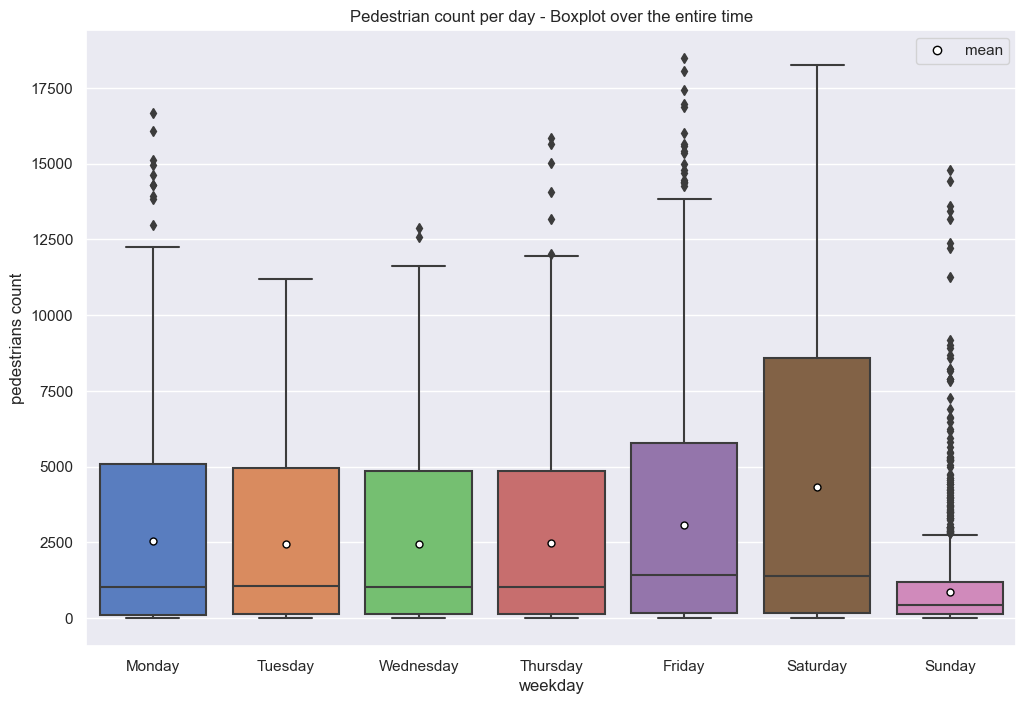

In [5]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", showmeans=True,  
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day - Boxplot over the entire time')
axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

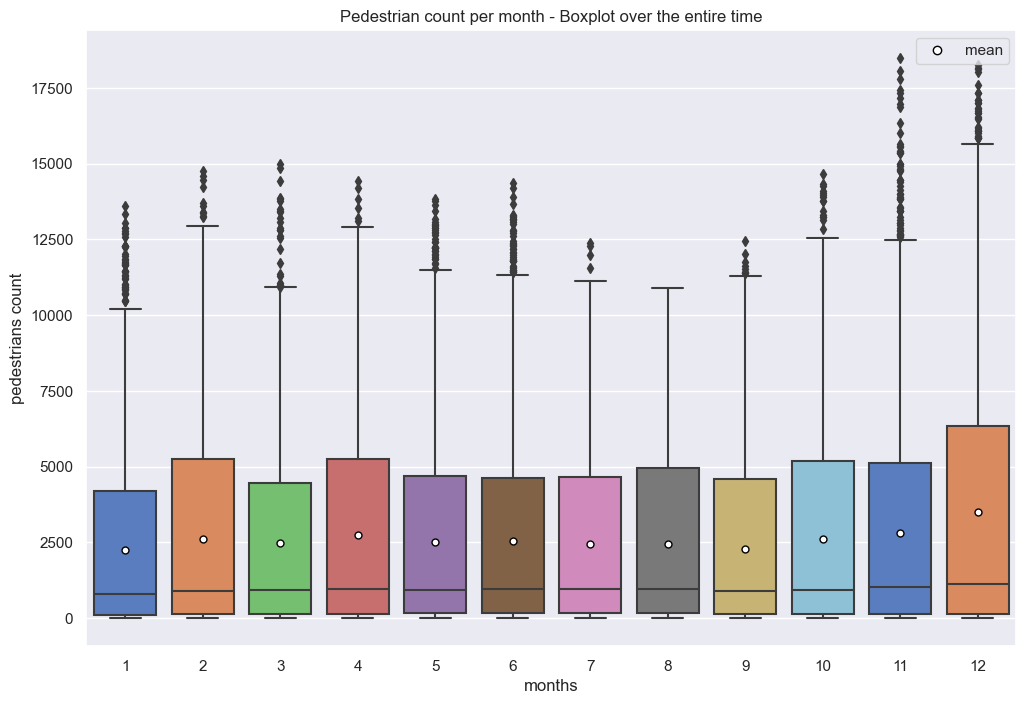

In [6]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, y="pedestrians count", x="months", palette="muted", showmeans=True, 
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per month - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

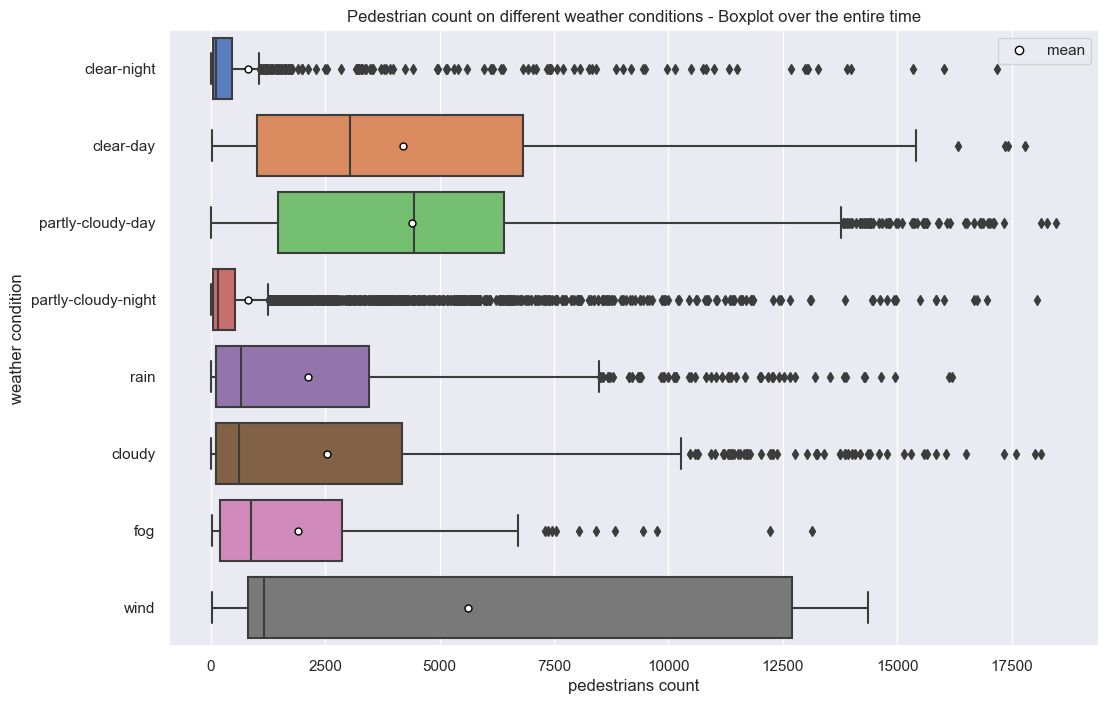

In [7]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"}) 

axs.set_title('Pedestrian count on different weather conditions - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])    

plt.show()

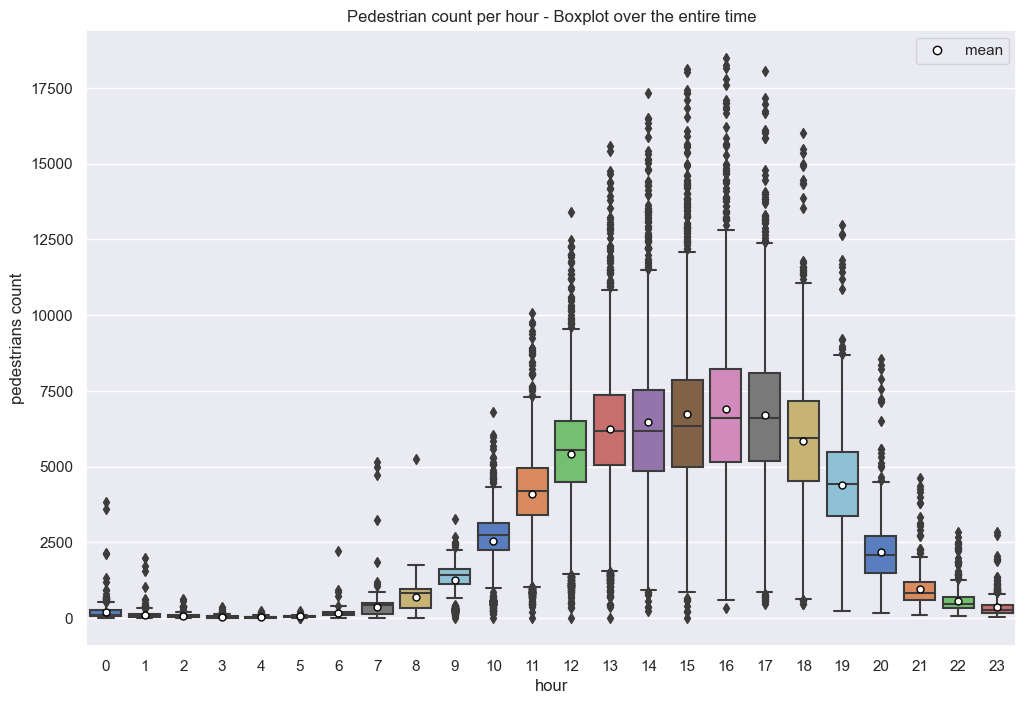

In [8]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per hour - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])   

plt.show()

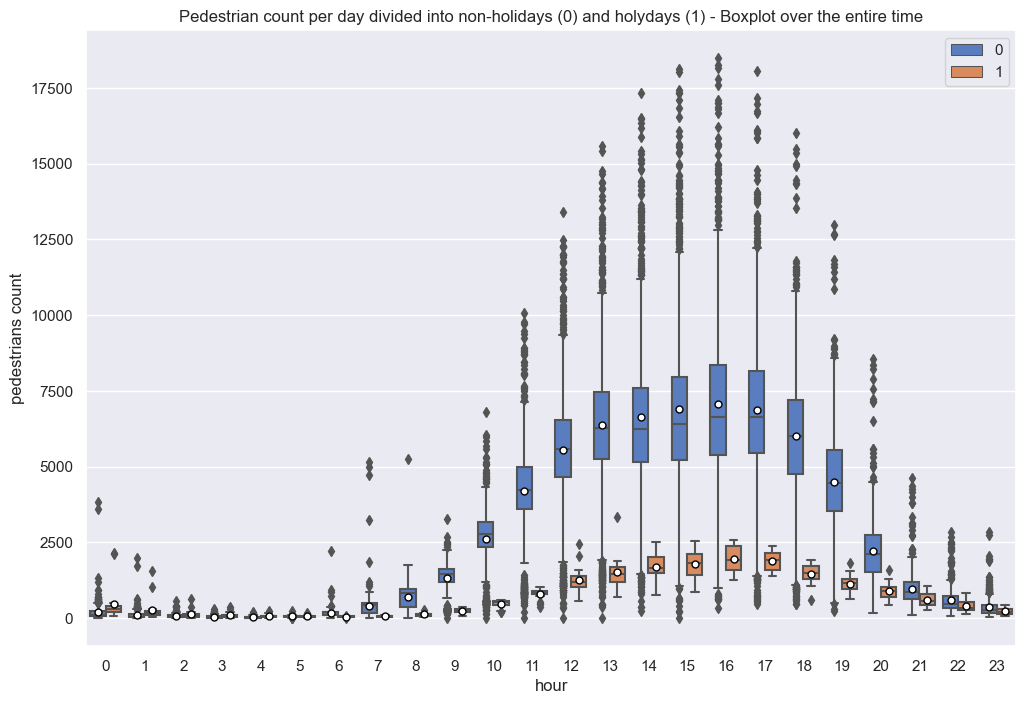

In [9]:
fig, axs = plt.subplots(figsize=(12,8))


sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day divided into non-holidays (0) and holydays (1) - Boxplot over the entire time')

axs.legend()

plt.show()

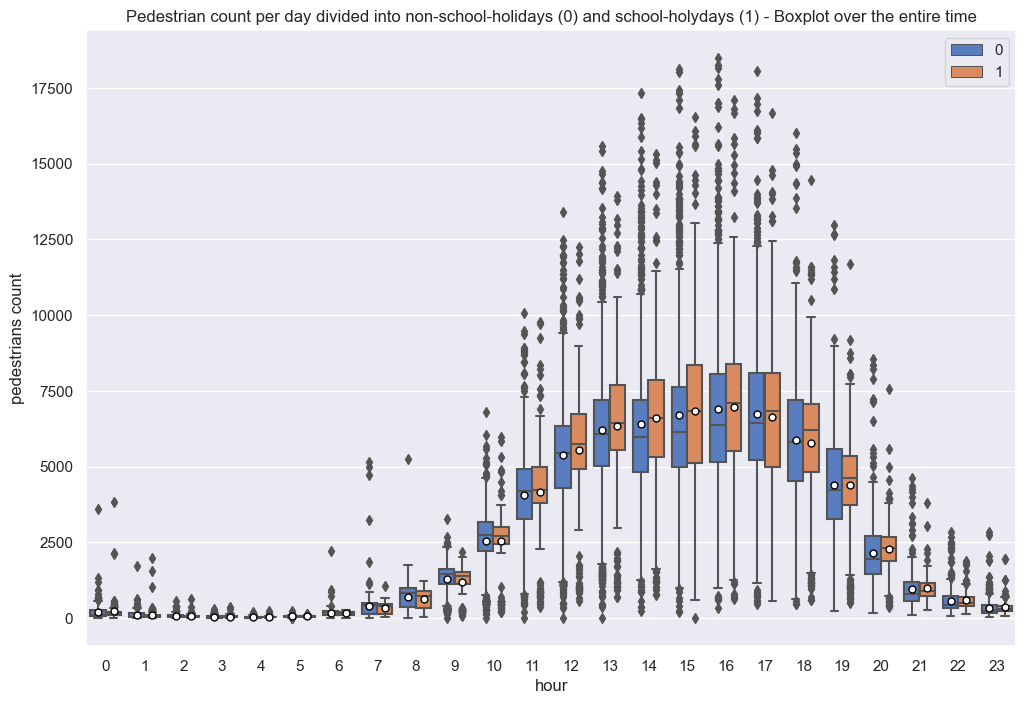

In [10]:
fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day divided into non-school-holidays (0) and school-holydays (1) - Boxplot over the entire time')

axs.legend()

plt.show()

### Baseline Model with Tensorflow

In [11]:
#Function to define two callbacks with certain parameters used for model fitting
def def_callbacks(stope_p = 10, reducelr_p=5, reducelr_lr=0.00001): #Use standard values when now argument is give n
    """
    stop_early patience = 10
    reduce_lr patience =5, reducelr learning rate=0.00001)
    """
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=stope_p) #Stop early stops the model fit once the Mean average error on the validation data doesn't improve after a certain amout of epochs 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, #Reduce the learning rate, by a factor of 0.2, when the Mean average error doesn't improve after a certain amout of epochs 
                              patience=reducelr_p, min_lr=reducelr_lr)
    callbacks_list = [stop_early,reduce_lr]
    return callbacks_list
    

In [12]:
#Define Baseline Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
tensorflow_base_model = keras.Sequential()

tensorflow_base_model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
tensorflow_base_model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 100 neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 25 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

tensorflow_base_model.summary()#Display an overview of the model 


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-04 17:51:07.057886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 17:51:07.058458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4700      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [13]:
#Specify the training configuration for the Neural Network
tensorflow_base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function the Optimizer minimizes --> Mean absolute error 
    metrics=["mae", RSquare()], # List of metrics to monitor
)


#Fit the model on the training data and use a validation split evaluate the model on
tensorflow_base_history = tensorflow_base_model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #The target variable used to calculate the mean absolut error between the target variable and the predictions of the model 
    epochs=250, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data and updates the weights 
    callbacks = def_callbacks(stope_p=20), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch
)

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 17:51:07.420259: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 17:51:08.095263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1766.1656 - mae: 1766.1656 - r_square: 0.1522

2022-12-04 17:51:11.633875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 5s 13ms/step - loss: 1766.1656 - mae: 1766.1656 - r_square: 0.1522 - val_loss: 918.0208 - val_mae: 918.0208 - val_r_square: 0.7572 - lr: 0.0010
Epoch 2/250
269/269 [==============================] - 3s 11ms/step - loss: 807.5182 - mae: 807.5182 - r_square: 0.7984 - val_loss: 671.6699 - val_mae: 671.6699 - val_r_square: 0.8469 - lr: 0.0010
Epoch 3/250
269/269 [==============================] - 3s 10ms/step - loss: 629.8431 - mae: 629.8431 - r_square: 0.8625 - val_loss: 575.5971 - val_mae: 575.5971 - val_r_square: 0.8821 - lr: 0.0010
Epoch 4/250
269/269 [==============================] - 3s 10ms/step - loss: 539.9036 - mae: 539.9036 - r_square: 0.8904 - val_loss: 514.5583 - val_mae: 514.5583 - val_r_square: 0.8981 - lr: 0.0010
Epoch 5/250
269/269 [==============================] - 3s 10ms/step - loss: 470.2929 - mae: 470.2929 - r_square: 0.9107 - val_loss: 458.9687 - val_mae: 458.9687 - val_r_square: 0.9147 - lr: 0.0010
Epoch 6/250
269/269 [====

#### Basemodel Evaluation

In [46]:
# Creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# Defining a function to fit the scenario and evaluate it
def scenario_evaluate_tensor(model, display_name, scenario, traindataX, traindatay, testdataX, testdatay, ):
    global comparison

    # Evaluate the model on the test data using `evaluate`. Results are the corresponding loss functin (MAE), MAE and R-squared (Metrics defined the model configuration)
    results = scenario.evaluate(Xtest, ytest)
    results_train = scenario.evaluate(Xtrain, ytrain)  

    # Compute the MAE
    mae_train = results_train[0] #First element is the loss function, Mean average error 
    mae_test = results[0] #First element is the loss function, Mean average error 
    # Comute R^2
    r2_train = results_train[2]
    r2_test = results[2]

    # Adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # Merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [47]:
scenario_evaluate_tensor(model="Tensorflow", display_name="Basemodel", scenario=tensorflow_base_model, traindataX=Xtrain, traindatay=ytrain, testdataX=Xtest, testdatay=ytest)

2022-12-04 19:41:44.702754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - 2s 7ms/step - loss: 278.3054 - mae: 278.3054 - r_square: 0.9490
        Model   Scenario   MAE_train    MAE_test  R2_train   R2_test
0  Tensorflow  Basemodel  278.305389  313.696442  0.949034  0.954566


#### Visualize the Model performance

 68/144 [=============>................] - ETA: 0s

2022-12-04 17:53:33.582294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 0s 2ms/step


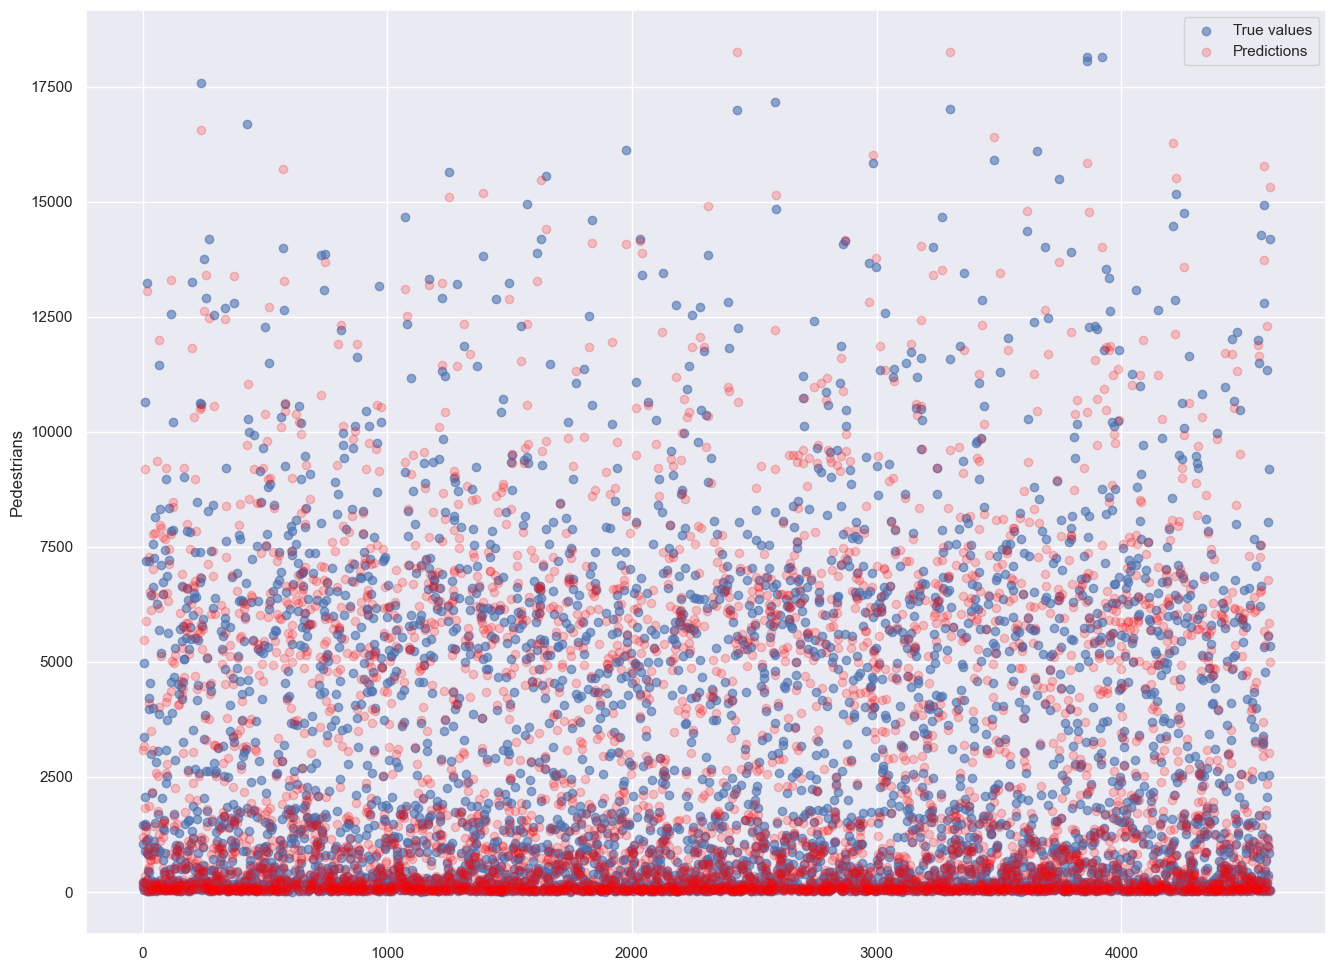

In [16]:
def plot_baseline(model, Xtest, ytest):
    # Plot the results to see the results of our base scenario
    fig, ax = plt.subplots(figsize=(16, 12))

    # Create a linspace to match the y-values
    xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

    # Plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="True values", alpha=0.6)

    # plot the predictions
    ypred = model.predict(Xtest)
    ax.scatter(xs, ypred, label="Predictions", color = "red", alpha=0.2)

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()

# Plot the Predictions and the Actual data for the Test set to get a first impression
plot_baseline(tensorflow_base_model, Xtest, ytest)

144/144 [==============================] - 1s 5ms/step - loss: 313.6964 - mae: 313.6964 - r_square: 0.9546


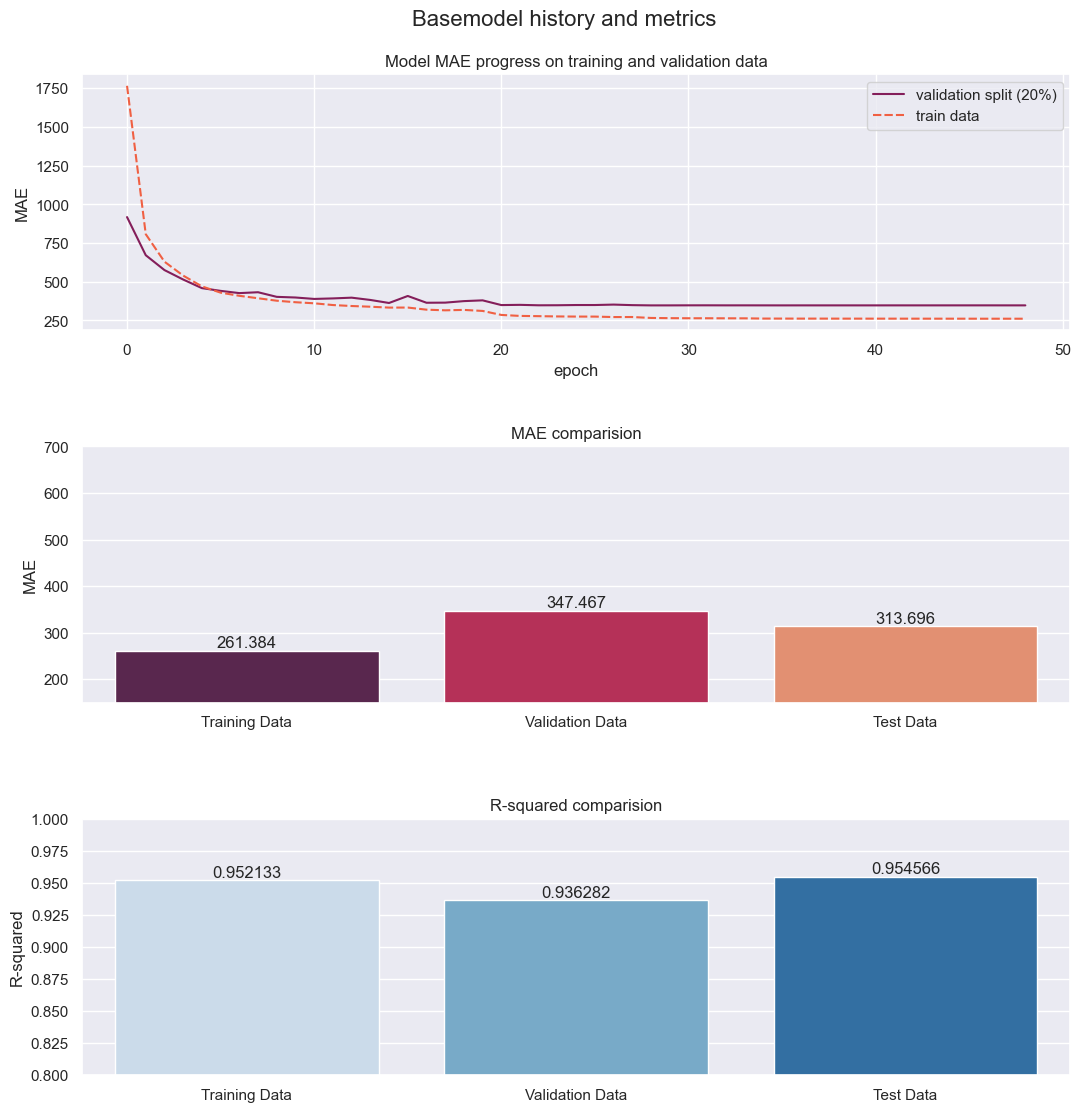

In [17]:
#Create a function to plot the MAE on the training data against the mae on the validation split of the Training data over time, 
#aswell as the MAE and R-squared on the Trainind data, validation data and Test Data
def tensorflow_history_plot(history, model, testdataX, testdatay, name ):
        fig, axs = plt.subplots(3, figsize=(12, 12))

        fig.tight_layout(pad=5.0)
        
        #Get the training mae and validation mae history 
        train_mae_his = history.history['mae']
        val_mae_his = history.history['val_mae']
        
        #Create a dataframe to concat the two together
        train_mae_his = pd.DataFrame (train_mae_his, columns = ['train data'])
        val_mae_his = pd.DataFrame (val_mae_his, columns = ['validation split (20%)'])

        #Create a singel combined dataframe and plot it
        mae_his = pd.concat([ val_mae_his, train_mae_his], axis=1)
        sns.lineplot(palette="rocket", ax=axs[0], data=mae_his, linestyle='--')
        axs[0].set_title('Model MAE progress on training and validation data')
        axs[0].set_ylabel('MAE')
        axs[0].set_xlabel('epoch')

        #Get the minimum training mae and validation mae aswell as the mae on the test data 
        f_mae = history.history["mae"]
        f_val_mae = history.history["val_mae"]
        f_test_mae = model.evaluate(Xtest, ytest)

        mae_ov = {'Training Data':  [min(f_mae)],
                'Validation Data': [min(f_val_mae)],
                'Test Data': [f_test_mae[0]]
                }

        #Create a dataframe to plot it
        mae_ov_df = pd.DataFrame(mae_ov)

        ax = sns.barplot(mae_ov_df,  palette="rocket", errwidth=0, ax=axs[1])
        ax.bar_label(ax.containers[0])
        axs[1].set_ylim([150, 700])
        axs[1].set_title('MAE comparision')
        axs[1].set_ylabel('MAE')

        #Get the maximum training r-squared and validation r-squared  aswell as the r-squared on the test data 
        f_r = history.history["r_square"]
        f_val_r = history.history["val_r_square"]

        r_ov = {'Training Data':  [max(f_r)],
                'Validation Data': [max(f_val_r)],
                'Test Data': [f_test_mae[2]]
                }
        #Create a dataframe and plot it
        r_ov_df = pd.DataFrame(r_ov)

        ax = sns.barplot(r_ov_df,  palette="Blues", errwidth=0, ax=axs[2])
        ax.bar_label(ax.containers[0])
        axs[2].set_ylim([0.8,1])
        axs[2].set_title('R-squared comparision')
        axs[2].set_ylabel('R-squared')
        fig.suptitle(f"{name} history and metrics", fontsize=16)
        fig.savefig(f"plots/{name} history_comparisson.png")


tensorflow_history_plot(history=tensorflow_base_history, model=tensorflow_base_model, testdataX=Xtest, testdatay=ytest, name="Basemodel")

### Hyperparameter tuning on 10% of the data

#### Basemodel on 10% of data

In [18]:
# Load the data and clean the Columns
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

#Create a subset with 50% of the data 
df_subset = df.sample(frac=0.1, random_state=1) 

# Define a new X with the squared feature k = 0.99, 57+46
X_subset = df_subset[df_subset.columns[57:103]]

# Output to predict
y_subset = df_subset["pedestrians count"]

# Split the dataset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)


In [19]:
#Basemodel on 10% data

#Create a Keras Sequential class to hold the different layers of our Neural Network
tensorflow_base2_model = keras.Sequential()

tensorflow_base2_model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
tensorflow_base2_model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 100 neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base2_model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base2_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base2_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base2_model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 25 neurones with Dense. 
tensorflow_base2_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base2_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base2_model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

tensorflow_base2_model.summary()#Display an overview of the model 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4700      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 10)                260       
                                                                 
 dense_14 (Dense)            (None, 10)               

In [20]:
#Specify the training configuration for the Neural Network
tensorflow_base2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function the Optimizer minimizes --> Mean absolute error 
    metrics=["mae", RSquare()], # List of metrics to monitor
)

#Fit the model an the training data and use a validation split evaluate the model on
tensorflow_base2_history = tensorflow_base2_model.fit(
    Xtrain_subset, # Fit the model on the train data subset (10%)
    ytrain_subset, #The target variable used to calculate the mean absolut error between the target variable and the predictions of the model. Subset (10% of data)
    epochs=250, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data and updates the weights 
    callbacks = def_callbacks(stope_p=20), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch
)

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


 1/27 [>.............................] - ETA: 11s - loss: 3145.3110 - mae: 3145.3110 - r_square: -0.8088

2022-12-04 17:53:36.035524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 1s 24ms/step - loss: 2412.1660 - mae: 2412.1660 - r_square: -0.6166 - val_loss: 2866.9905 - val_mae: 2866.9905 - val_r_square: -0.6835 - lr: 0.0010
Epoch 2/250
 1/27 [>.............................] - ETA: 0s - loss: 2146.2778 - mae: 2146.2778 - r_square: -0.4623

2022-12-04 17:53:36.692989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 12ms/step - loss: 2386.0491 - mae: 2386.0491 - r_square: -0.6021 - val_loss: 2794.4514 - val_mae: 2794.4514 - val_r_square: -0.6399 - lr: 0.0010
Epoch 3/250
27/27 [==============================] - 0s 11ms/step - loss: 2215.5439 - mae: 2215.5439 - r_square: -0.4313 - val_loss: 2467.3284 - val_mae: 2467.3284 - val_r_square: -0.2696 - lr: 0.0010
Epoch 4/250
27/27 [==============================] - 0s 12ms/step - loss: 1932.6362 - mae: 1932.6362 - r_square: 0.0417 - val_loss: 2131.3564 - val_mae: 2131.3564 - val_r_square: 0.0363 - lr: 0.0010
Epoch 5/250
27/27 [==============================] - 0s 11ms/step - loss: 1637.0599 - mae: 1637.0599 - r_square: 0.2649 - val_loss: 1824.3138 - val_mae: 1824.3138 - val_r_square: 0.2797 - lr: 0.0010
Epoch 6/250
27/27 [==============================] - 0s 14ms/step - loss: 1426.9088 - mae: 1426.9088 - r_square: 0.3908 - val_loss: 1655.9773 - val_mae: 1655.9773 - val_r_square: 0.3332 - lr: 0.0010
Epoch 7/250
2

In [48]:
scenario_evaluate_tensor(model="Tensorflow subset", display_name="Basemodel subset", scenario=tensorflow_base2_model, traindataX=Xtrain_subset, traindatay=ytrain_subset, testdataX=Xtest_subset, testdatay=ytest_subset)

336/336 [==============================] - 2s 6ms/step - loss: 641.7651 - mae: 641.7651 - r_square: 0.8544
               Model          Scenario   MAE_train    MAE_test  R2_train  \
0         Tensorflow         Basemodel  278.305389  313.696442  0.949034   
1  Tensorflow subset  Basemodel subset  641.765137  633.243530  0.854369   

    R2_test  
0  0.954566  
1  0.864704  


#### Hypertuned model: Optimal number of layers and nodes on 10% of the data 

In [22]:
## Hyperparametertuning

def tensorflow_h0_model(hp): 
 
    #Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()
    model.add(keras.layers.Flatten()) #Add an input layer 
    
# Tune the number of hidden layers and units (Nodes)
    # Number of hidden layers: 1 - 16
    for i in range(hp.Int("num_layers", 1, 16)):
        
        # Number of Nodes: 32 - 256 with stepsize of 32
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32), #Define a Hyperparameter as a integer between 32 and 256 as different amount of Nodes 
                activation="relu") #Using relu as an activation function. Could also be defined as a Hyperparameter but in order to reduce the computing time, this will be done in the next Hyperparameter tuning
            )
    
    # Add output layer
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting learning rate as a Hyperparameter would be better but it would take a lot longer since the Tuner would also have to tune the learning rate adding a huge amout of options.
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae", RSquare()]) 
    
    return model

# Using the Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
tensorflow_h0_tuner = kt.Hyperband(hypermodel=tensorflow_h0_model, #Select the model that should be tuned
                     objective='val_mae', #Objective to minimize, in this case the validation split Mean average error
                     max_epochs=30, #Maximum number of epochs to train 1 model configuration 
                     hyperband_iterations=2, #the number of times to iterate over the full Hyperband algorithm
                     overwrite=True, #to be able to overwrite prior tuner entries
                     directory='kt_dir',
                     project_name='kt_Hyperband0')

#Start the Hyperparamter search on the smaller subset data (10%) 
tensorflow_h0_tuner.search(Xtrain_subset, ytrain_subset, epochs=30, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001, reducelr_p=3))


Trial 180 Complete [00h 00m 12s]
val_mae: 2871.916259765625

Best val_mae So Far: 603.6363525390625
Total elapsed time: 00h 40m 34s
INFO:tensorflow:Oracle triggered exit


Trial 180 Complete [00h 00m 54s]
val_mae: 340.620849609375

Best val_mae So Far: 337.7674560546875
Total elapsed time: 03h 33m 19s
INFO:tensorflow:Oracle triggered exit

In [23]:
#Safe the best Hyperparamter configurations
h0_best_hps = tensorflow_h0_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The first hyperparameter search on the smaller dataset is complete. The optimal number of layers is {h0_best_hps.get('num_layers')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
tensorflow_h0_tuner.results_summary()


The first hyperparameter search on the smaller dataset is complete. The optimal number of layers is 11.
Summary:

Results summary
Results in kt_dir/kt_Hyperband0
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 64
units_2: 192
units_3: 96
units_4: 160
units_5: 128
units_6: 32
units_7: 160
units_8: 64
units_9: 128
units_10: 96
units_11: 224
units_12: 96
units_13: 192
units_14: 160
units_15: 224
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0171
Score: 603.6363525390625
Trial summary
Hyperparameters:
num_layers: 14
units_0: 128
units_1: 256
units_2: 256
units_3: 128
units_4: 192
units_5: 224
units_6: 256
units_7: 224
units_8: 64
units_9: 224
units_10: 96
units_11: 64
units_12: 256
units_13: 192
units_14: 192
units_15: 128
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0170
Score: 607.1768188476562
Trial summary
Hyperparameters:
num_layers: 11
units_0: 224
units_1

The first hyperparameter search on the smaller dataset is complete. The optimal number of layers is 8.
Summary:

Results summary
Results in kt_dir/kt_Hyperband0
Showing 10 best trials
<keras_tuner.engine.objective.Objective object at 0x2d84c6230>
Trial summary
Hyperparameters:
num_layers: 8
units_0: 160
units_1: 192
units_2: 64
units_3: 160
units_4: 128
units_5: 160
units_6: 64
units_7: 224
units_8: 96
units_9: 64
units_10: 160
units_11: 64
units_12: 128
units_13: 96
units_14: 192
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0139
Score: 610.714599609375
Trial summary
Hyperparameters:
num_layers: 11
units_0: 224
units_1: 160
units_2: 192
units_3: 160
units_4: 160
units_5: 224
units_6: 64
units_7: 224
units_8: 32
units_9: 224
units_10: 224
units_11: 64
units_12: 224
units_13: 32
units_14: 224
units_15: 128
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0159
Score: 615.2667846679688
Trial summary
Hyperparameters:
num_layers: 12
units_0: 128
units_1: 64
units_2: 160
units_3: 96
units_4: 192
units_5: 128
units_6: 192
units_7: 96
units_8: 32
units_9: 160
units_10: 128
units_11: 64
units_12: 128
units_13: 192
units_14: 160
units_15: 128
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 627.05908203125
Trial summary
Hyperparameters:
num_layers: 10
units_0: 160
units_1: 224
units_2: 160
units_3: 160
units_4: 64
units_5: 128
units_6: 128
units_7: 32
units_8: 224
units_9: 160
units_10: 64
units_11: 224
units_12: 192
units_13: 64
units_14: 224
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 629.0050659179688
Trial summary
Hyperparameters:
num_layers: 8
units_0: 96
units_1: 64
units_2: 128
units_3: 192
units_4: 32
units_5: 96
units_6: 192
units_7: 96
units_8: 96
units_9: 160
units_10: 192
units_11: 224
units_12: 32
units_13: 256
units_14: 64
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0069
Score: 630.0343017578125
Trial summary
Hyperparameters:
num_layers: 8
units_0: 224
units_1: 64
units_2: 96
units_3: 160
units_4: 256
units_5: 128
units_6: 96
units_7: 64
units_8: 64
units_9: 64
units_10: 64
units_11: 128
units_12: 96
units_13: 160
units_14: 128
units_15: 224
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 633.1080932617188
Trial summary
Hyperparameters:
num_layers: 6
units_0: 160
units_1: 64
units_2: 96
units_3: 224
units_4: 192
units_5: 128
units_6: 192
units_7: 64
units_8: 192
units_9: 64
units_10: 32
units_11: 32
units_12: 192
units_13: 96
units_14: 160
units_15: 192
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 634.2846069335938
Trial summary
Hyperparameters:
num_layers: 4
units_0: 224
units_1: 32
units_2: 128
units_3: 192
units_4: 160
units_5: 64
units_6: 256
units_7: 192
units_8: 32
units_9: 32
units_10: 192
units_11: 64
units_12: 128
units_13: 96
units_14: 128
units_15: 128
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0158
Score: 635.19140625
Trial summary
Hyperparameters:
num_layers: 12
units_0: 32
units_1: 96
units_2: 224
units_3: 256
units_4: 96
units_5: 128
units_6: 96
units_7: 128
units_8: 64
units_9: 192
units_10: 160
units_11: 160
units_12: 224
units_13: 32
units_14: 160
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 642.4606323242188
Trial summary
Hyperparameters:
num_layers: 4
units_0: 160
units_1: 192
units_2: 224
units_3: 224
units_4: 224
units_5: 192
units_6: 32
units_7: 224
units_8: 224
units_9: 256
units_10: 224
units_11: 128
units_12: 192
units_13: 128
units_14: 128
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0074
Score: 642.6329956054688

#### Hypertuned model: Tuning Optimzer, learning rate and activation function (Hyperparameter)
##### This approach is used to reduce the computing time. A better way would be to include these as Hyperparameter in the tuning above.

In [24]:
#Find the best Optimizer, activation fucntion and learning rate for the best Model the above Tuner has found

def tensorflow_h1_model(hp): 
 
#Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()

    #Tune activation function
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'selu']) #Define a Hyperparameter as a choiche (option) for different activation functions. The tuner will try these, to find the best one (lowest validation MAE)

    #Best Neural Network configuration found by the first Hyperparameter tuner
    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input
    model.add(layers.Dense(160, activation=hp_activation))  
    model.add(layers.Dense(192, activation=hp_activation)) 
    model.add(layers.Dense(64, activation=hp_activation)) 
    model.add(layers.Dense(160, activation=hp_activation))
    model.add(layers.Dense(128, activation=hp_activation)) 
    model.add(layers.Dense(160, activation=hp_activation))  
    model.add(layers.Dense(64, activation=hp_activation))  
    model.add(layers.Dense(224, activation=hp_activation))   
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])  # Define a Hyperparameter as a choice to tune learning rate with the values 0.01, 0.001, 0.0001

    #Create a dictionary to hold the different optimization functions 
    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice( #Define a Hyperparameter as a choice to tune the optimizer 
        'optimizer', values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"] #Options the tuner will try, that correspond to the optimizer dictionary keys 
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers], #Complie the model and use the optimizer choice as input for the optimizer 
                  loss=keras.losses.mae, #Loss function is Mean average error 
                  metrics=["mae", RSquare()]) #Metrics to monitor
    
    return model

In [25]:
#Random search tuner because we only have 5 different Optimizer options, 3 learning rate optimizations and 3 activation functions, 
# so randomly selecting is okay because no matter what we will try every combination in a rather short time
tensorflow_h1_tuner = kt.RandomSearch(hypermodel = tensorflow_h1_model, #The model the Randomsearch tuner will tune 
                       objective = 'val_mae', #Objetive the tuner will try to minimize 
                       max_trials =100 , #The total number of model configurations to test at most 
                       directory = 'kt_dir', #create a dictionary to store the tries and metrics 
                       overwrite=True, #To be able to overwrite prior tuner entries
                       project_name = 'kt_RandomSearch')

In [26]:
#Initiate the tuner with the Train data
#Tune for 20 epochs with a validation split of 20% and a possible minimum learning rate of 0.00001 for the Reduce learning rate callback function
tensorflow_h1_tuner.search(Xtrain_subset, ytrain_subset, epochs=20, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.00001)) 

Trial 38 Complete [00h 00m 28s]
val_mae: 2871.4697265625

Best val_mae So Far: 559.9421997070312
Total elapsed time: 00h 34m 28s
INFO:tensorflow:Oracle triggered exit


Trial 38 Complete [00h 00m 28s]
val_mae: 2871.4697265625

Best val_mae So Far: 559.9421997070312
Total elapsed time: 00h 34m 28s
INFO:tensorflow:Oracle triggered exit

#### Fitting Hypertuned model on 10% of the data

In [27]:
#Create a new Model with the best Hyperparameters found by the tuner
h1_best_hps = tensorflow_h1_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The second hyperparameter search is complete. The best optimizer is {h1_best_hps.get('optimizer')}, the best activation function is 
{h1_best_hps.get("activation")} and the optimal learning rate for the optimizer is {h1_best_hps.get('learning_rate')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
tensorflow_h1_tuner.results_summary() 

#Create a new Hypertuned Model to tune further, with the best Hyperparameter configurations the tuner has found.
tensorflow_hypertuned_model = tensorflow_h1_tuner.hypermodel.build(h1_best_hps)
#Fit the model on the hole training data set and create a new history for the model to compare it with the Baseline histroy 
tensorflow_hypertuned_history = tensorflow_hypertuned_model.fit(Xtrain_subset, ytrain_subset, epochs=250, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The second hyperparameter search is complete. The best optimizer is Adagrad, the best activation function is 
selu and the optimal learning rate for the optimizer is 0.01.
Summary:

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.01
optimizer: Adagrad
Score: 559.9421997070312
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: RMSprop
Score: 587.4118041992188
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: RMSprop
Score: 628.2323608398438
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adam
Score: 650.3575439453125
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: Adam
Score: 679.4531860351562
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optimizer: Adam
Score: 681.1668090820312
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer:

/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 19:09:02.192372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - ETA: 0s - loss: 1857.4414 - mae: 1857.4414 - r_square: 0.0085 

2022-12-04 19:09:12.111520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 14s 378ms/step - loss: 1857.4414 - mae: 1857.4414 - r_square: 0.0085 - val_loss: 1409.4819 - val_mae: 1409.4819 - val_r_square: 0.5525 - lr: 0.0100
Epoch 2/250
27/27 [==============================] - 3s 105ms/step - loss: 1135.9683 - mae: 1135.9683 - r_square: 0.6085 - val_loss: 1102.1035 - val_mae: 1102.1035 - val_r_square: 0.7227 - lr: 0.0100
Epoch 3/250
27/27 [==============================] - 2s 61ms/step - loss: 937.4520 - mae: 937.4520 - r_square: 0.7354 - val_loss: 1150.8390 - val_mae: 1150.8390 - val_r_square: 0.6875 - lr: 0.0100
Epoch 4/250
27/27 [==============================] - 2s 63ms/step - loss: 820.6663 - mae: 820.6663 - r_square: 0.7854 - val_loss: 935.1051 - val_mae: 935.1051 - val_r_square: 0.7930 - lr: 0.0100
Epoch 5/250
27/27 [==============================] - 1s 46ms/step - loss: 708.5115 - mae: 708.5115 - r_square: 0.8351 - val_loss: 848.8849 - val_mae: 848.8849 - val_r_square: 0.7284 - lr: 0.0100
Epoch 6/250
27/27 [=====



The second hyperparameter search is complete. The best optimizer is RMSprop, the best activation function is 
selu and the optimal learning rate for the optimizer is 0.001.
Summary:

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
<keras_tuner.engine.objective.Objective object at 0x291d5b880>
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: RMSprop
Score: 328.4117736816406
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adagrad
Score: 331.3777770996094
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: Adam
Score: 350.44842529296875
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.01
optimizer: Adagrad
Score: 350.83795166015625
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adam
Score: 358.27471923828125
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.0001
optimizer: SGD
Score: 373.338623046875
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.0001
optimizer: Adam
Score: 381.71136474609375
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: RMSprop
Score: 402.0851135253906
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.0001
optimizer: RMSprop
Score: 405.0840759277344
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimizer: RMSprop
Score: 426.29180908203125
Epoch 1/250

#### Hypertuned model Evaluation

In [49]:
#Evaluate model on test set using the above created function to save the results in the comparisson dataframe
scenario_evaluate_tensor(model="Tensorflow subset", display_name="Hypertuned model subset", scenario=tensorflow_hypertuned_model, traindataX=Xtrain_subset, traindatay=ytrain_subset, testdataX=Xtest_subset, testdatay=ytest_subset)

336/336 [==============================] - 4s 12ms/step - loss: 541.5097 - mae: 541.5097 - r_square: 0.8818
               Model                 Scenario   MAE_train    MAE_test  \
0         Tensorflow                Basemodel  278.305389  313.696442   
1  Tensorflow subset         Basemodel subset  641.765137  633.243530   
2  Tensorflow subset  Hypertuned model subset  541.509705  523.257874   

   R2_train   R2_test  
0  0.949034  0.954566  
1  0.854369  0.864704  
2  0.881766  0.895139  


#### Viusalize the Hypertuned Model 

2022-12-04 19:09:48.594199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 3s 16ms/step


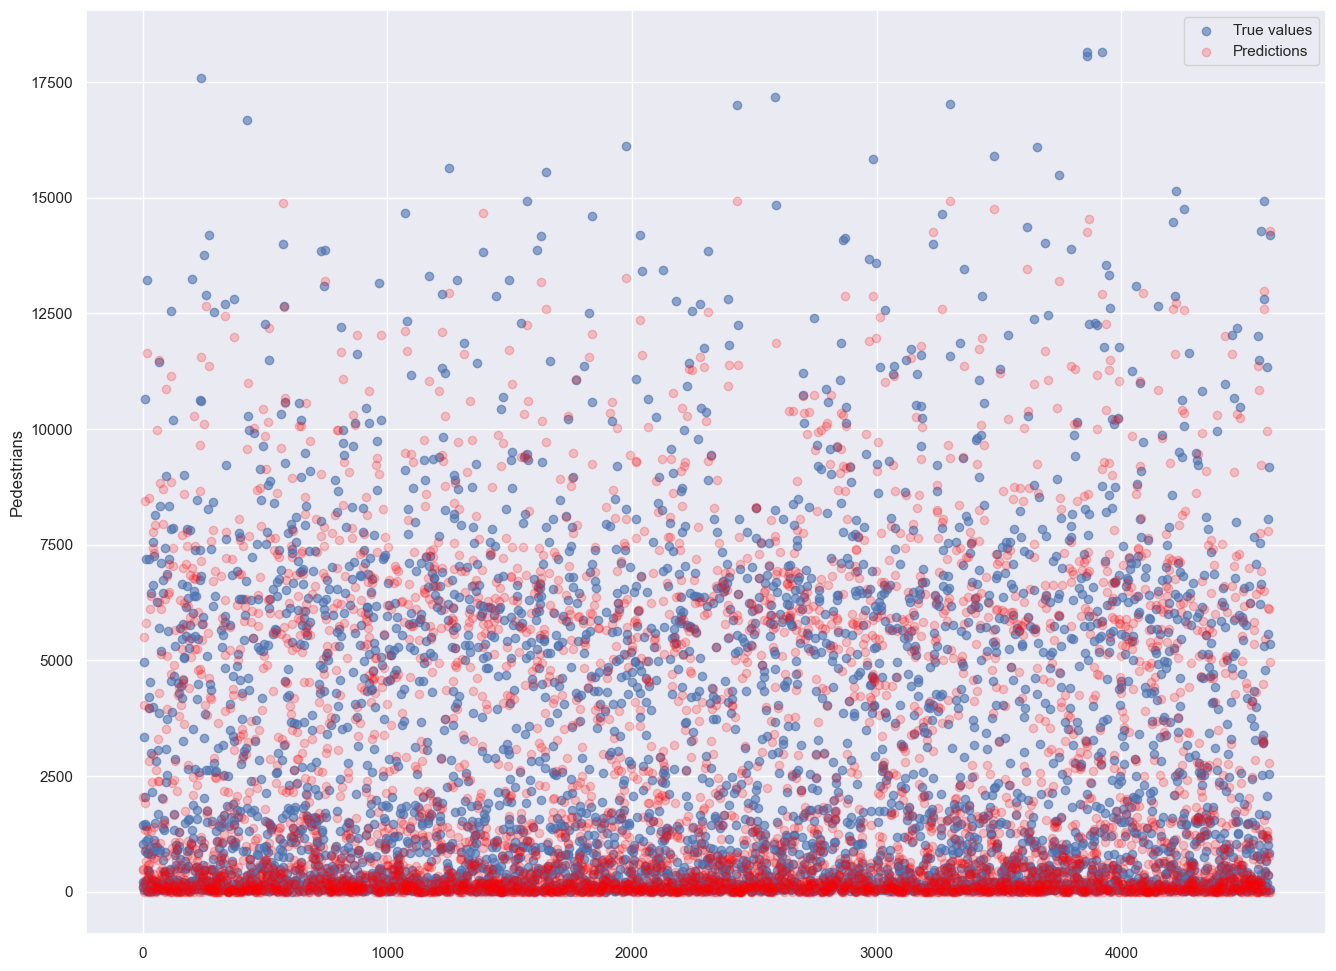

In [29]:
#Visualize the results predictions vs actual values
plot_baseline(tensorflow_hypertuned_model, Xtest, ytest)

144/144 [==============================] - 2s 11ms/step - loss: 523.2579 - mae: 523.2579 - r_square: 0.8951


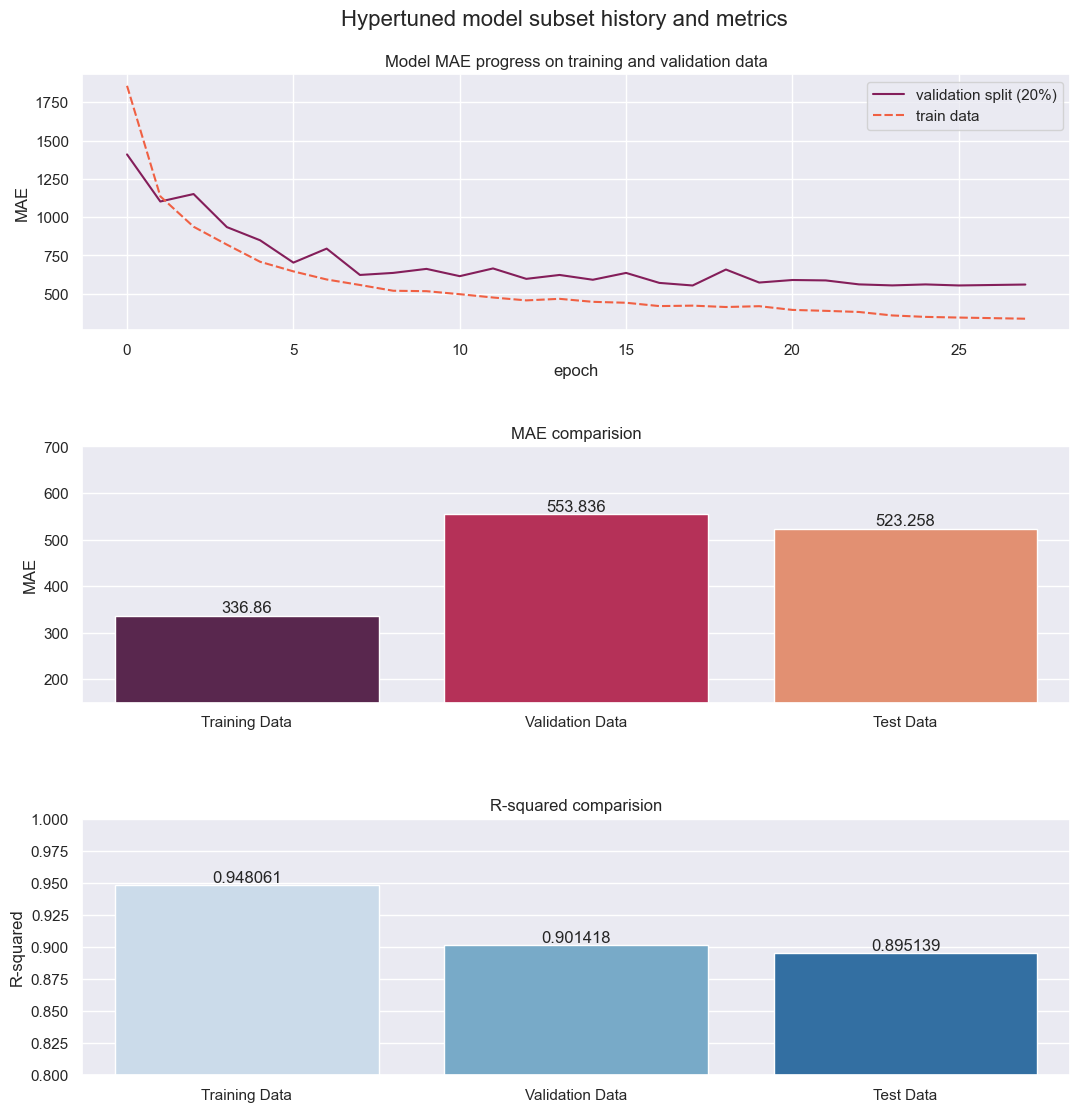

In [30]:
#Plot the MAE on the training data against the validation split of the Training data over time, aswell as the MAE and R-squared on the Trainind data, validation data and Test Data
tensorflow_history_plot(history=tensorflow_hypertuned_history, model=tensorflow_hypertuned_model, testdataX=Xtest_subset, testdatay=ytest_subset, name="Hypertuned model subset")

### Hypertuned model fit on 100% of the dataset

In [41]:
#Create a second Hypertuned Model to tune further, with the best Hyperparameter configurations the tuner has found.
tensorflow_full_hypertuned_model = tensorflow_h1_tuner.hypermodel.build(h1_best_hps)

#Fitting the hypertuned model on 100% of the data. In order to compare it to the baseline model which was fitted on 100% of the data.
#This approach is choosen to reduce computing time, if this was not of concern the tuning would have been done on the whole dataset
tensorflow_full_hypertuned_history = tensorflow_full_hypertuned_model.fit(Xtrain, ytrain, epochs=250, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001, reducelr_p=10, stope_p=25))

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 19:23:20.974643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1000.3796 - mae: 1000.3796 - r_square: 0.6858

2022-12-04 19:23:38.428265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 24s 71ms/step - loss: 1000.3796 - mae: 1000.3796 - r_square: 0.6858 - val_loss: 599.3888 - val_mae: 599.3888 - val_r_square: 0.8668 - lr: 0.0100
Epoch 2/250
269/269 [==============================] - 7s 26ms/step - loss: 590.2592 - mae: 590.2592 - r_square: 0.8711 - val_loss: 522.9161 - val_mae: 522.9161 - val_r_square: 0.8940 - lr: 0.0100
Epoch 3/250
269/269 [==============================] - 7s 25ms/step - loss: 513.3827 - mae: 513.3827 - r_square: 0.8975 - val_loss: 480.5012 - val_mae: 480.5012 - val_r_square: 0.9064 - lr: 0.0100
Epoch 4/250
269/269 [==============================] - 7s 26ms/step - loss: 483.2404 - mae: 483.2404 - r_square: 0.9046 - val_loss: 467.2555 - val_mae: 467.2555 - val_r_square: 0.9084 - lr: 0.0100
Epoch 5/250
269/269 [==============================] - 7s 26ms/step - loss: 454.5116 - mae: 454.5116 - r_square: 0.9138 - val_loss: 479.7271 - val_mae: 479.7271 - val_r_square: 0.9044 - lr: 0.0100
Epoch 6/250
269/269 [===

#### Evaluating the model

In [50]:
#Evaluate model on test set using the above created function to save the results in the comparisson dataframe
scenario_evaluate_tensor(model="Tensorflow", display_name="Hypertuned model", scenario=tensorflow_full_hypertuned_model, traindataX=Xtrain, traindatay=ytrain, testdataX=Xtest, testdatay=ytest)

336/336 [==============================] - 4s 12ms/step - loss: 256.8132 - mae: 256.8132 - r_square: 0.9519
               Model                 Scenario   MAE_train    MAE_test  \
0         Tensorflow                Basemodel  278.305389  313.696442   
1  Tensorflow subset         Basemodel subset  641.765137  633.243530   
2  Tensorflow subset  Hypertuned model subset  541.509705  523.257874   
3         Tensorflow         Hypertuned model  256.813232  298.987701   

   R2_train   R2_test  
0  0.949034  0.954566  
1  0.854369  0.864704  
2  0.881766  0.895139  
3  0.951947  0.957310  


#### Visualize

2022-12-04 19:21:17.818681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 3s 16ms/step


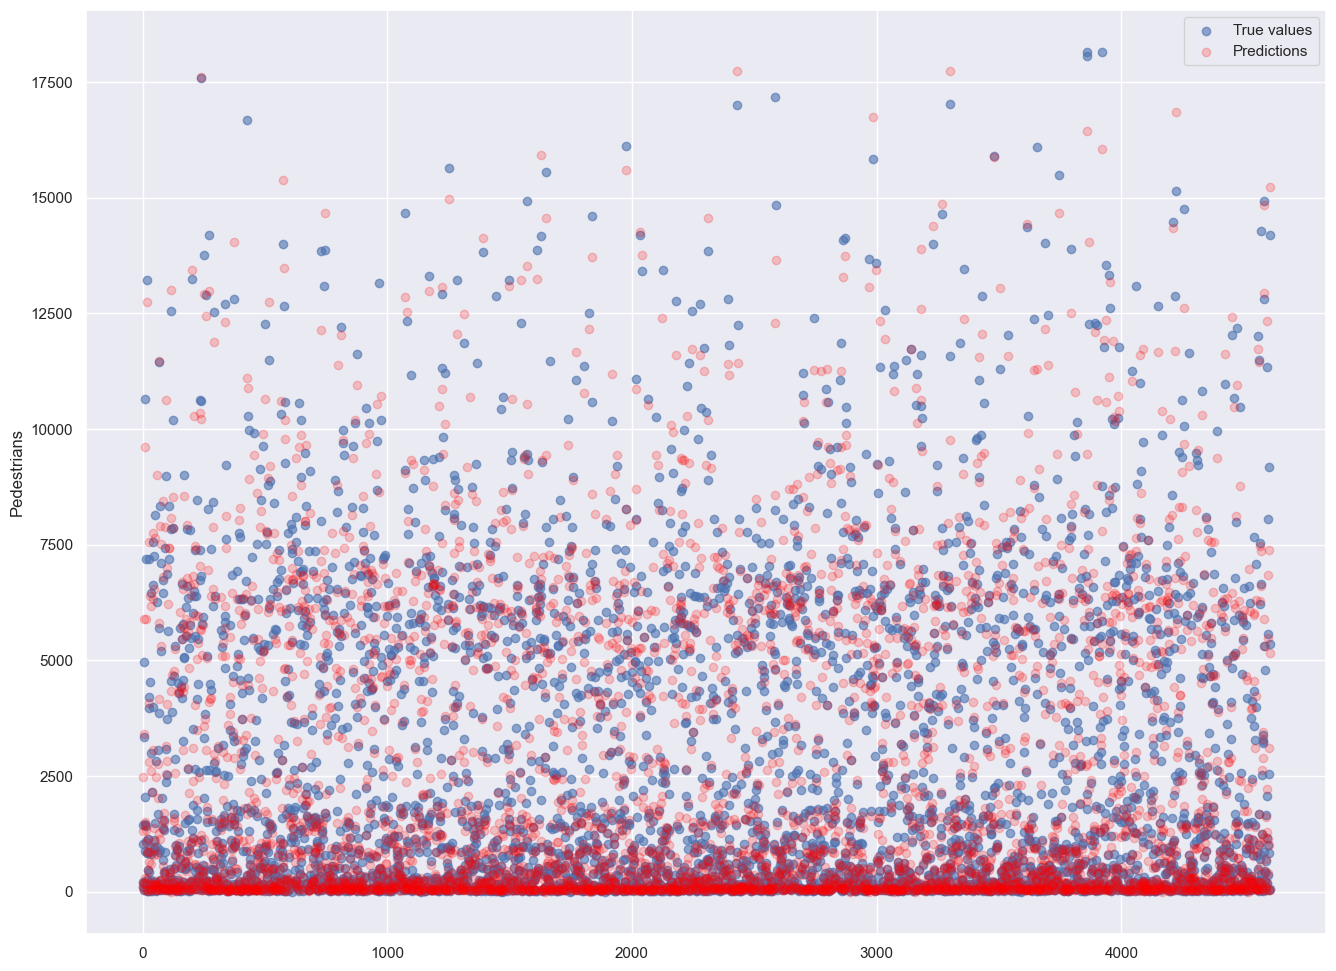

In [33]:
#Visualize the results predictions vs actual values
plot_baseline(tensorflow_full_hypertuned_model, Xtest, ytest)

144/144 [==============================] - 2s 12ms/step - loss: 298.9877 - mae: 298.9877 - r_square: 0.9573


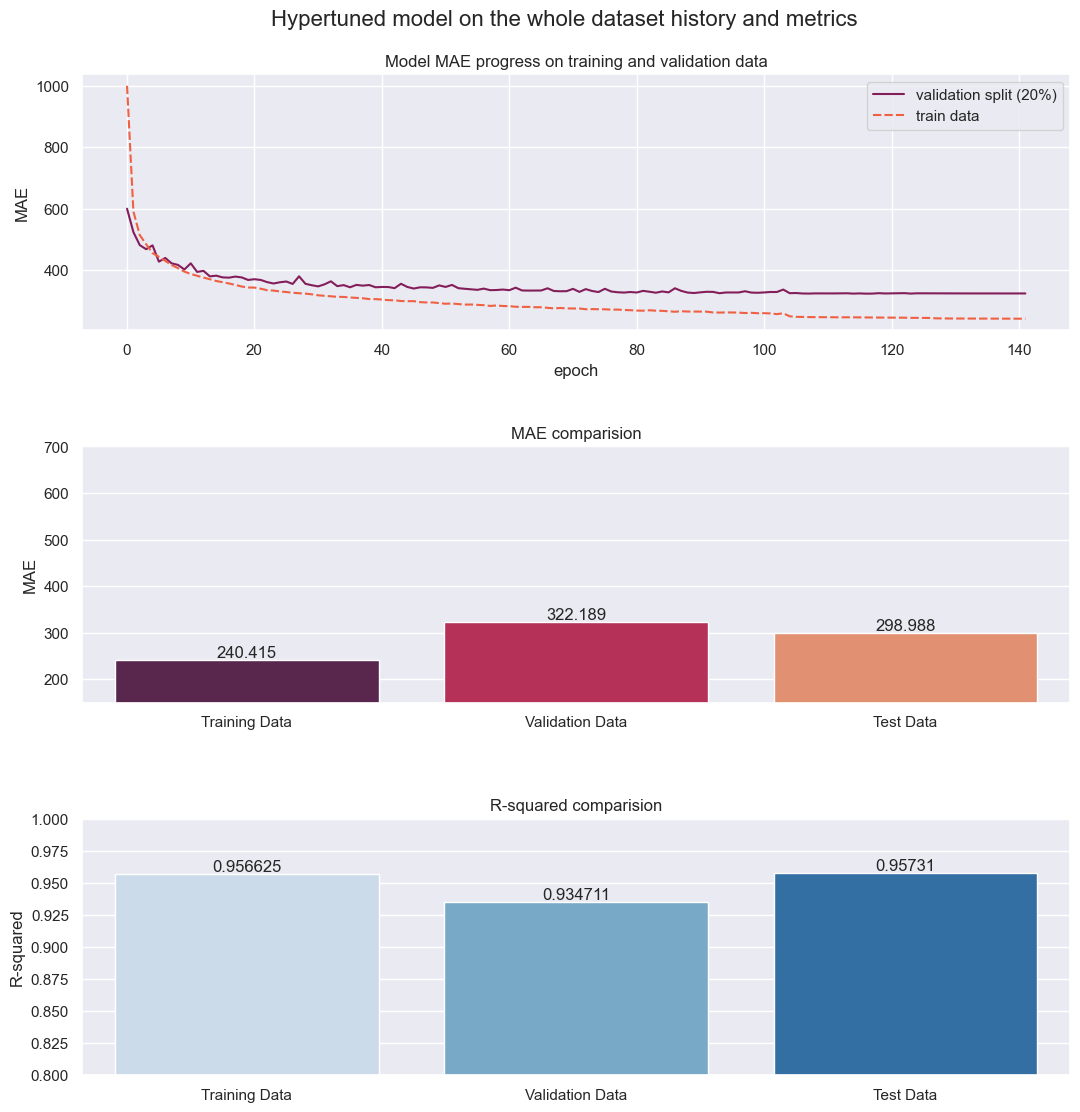

In [51]:
#Plot the MAE on the training data against the validation split of the Training data over time, aswell as the MAE and R-squared on the Trainind data, validation data and Test Data
tensorflow_history_plot(history=tensorflow_full_hypertuned_history, model=tensorflow_full_hypertuned_model, testdataX=Xtest, testdatay=ytest, name="Hypertuned model on the whole dataset")

### Model performance comparisson

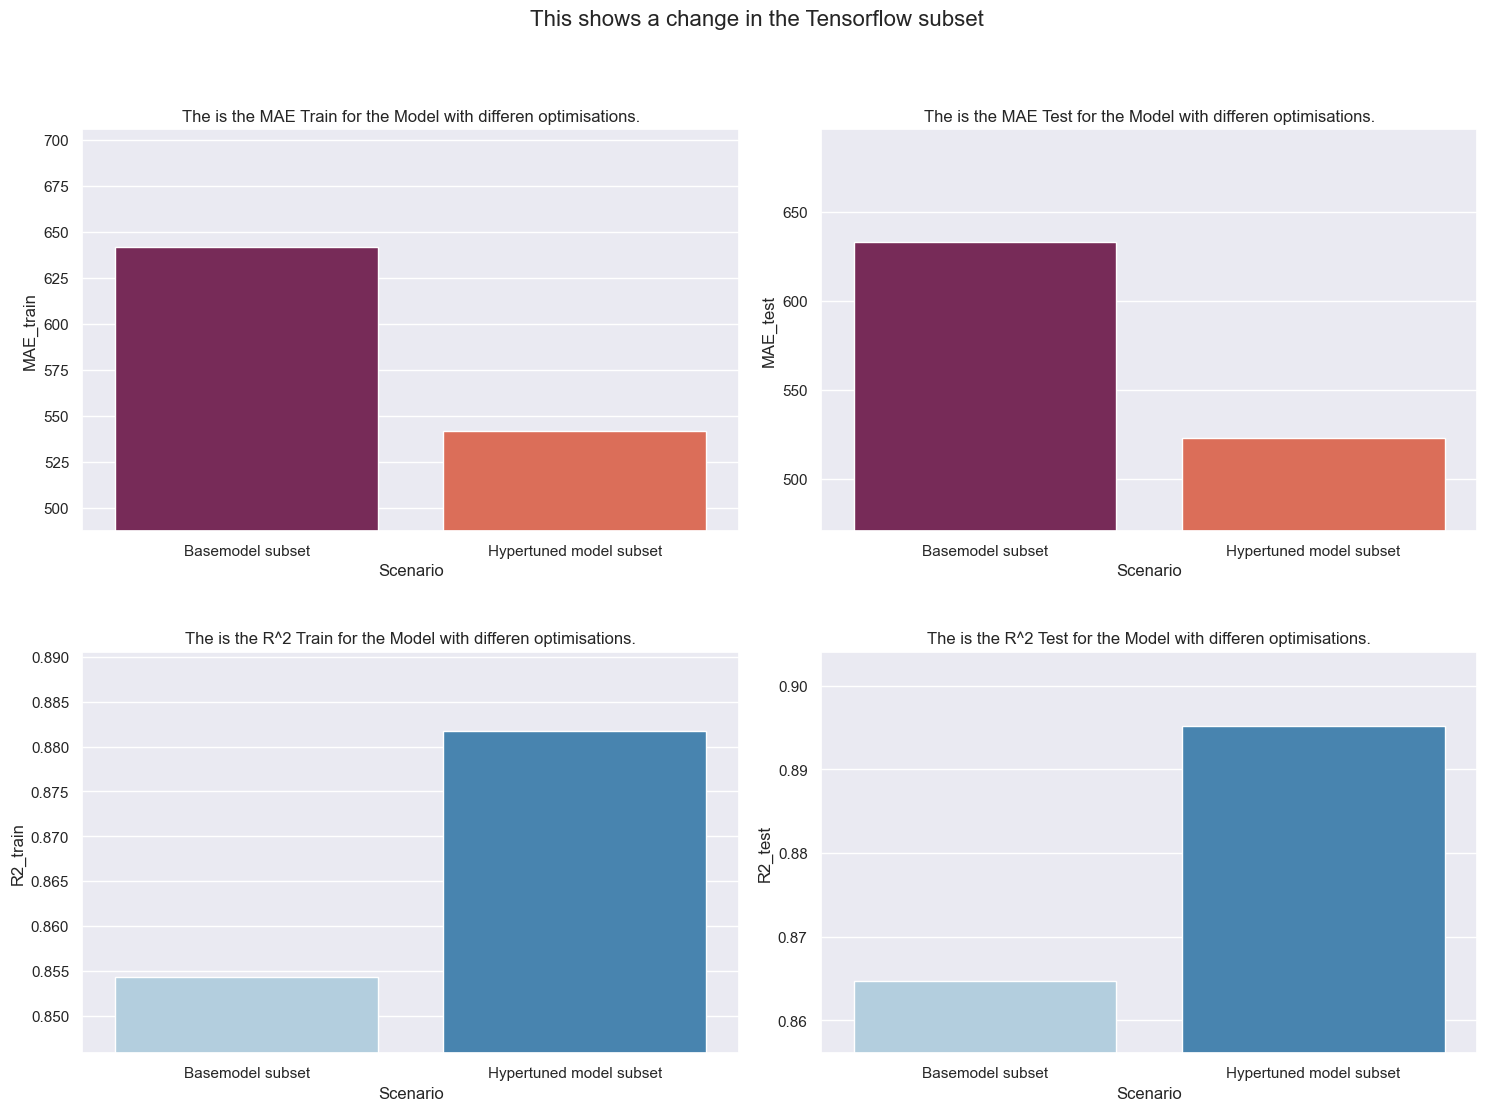

In [52]:
#Define a Function to plot the comparison of the models
def plot_bars_comp(model, dataframe):
    # Define the dimensions and model of the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_data = dataframe[dataframe["Model"] == model]

    # Get the MAE train bars
    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim((plot_data["MAE_train"].min())*0.9, (plot_data["MAE_train"].max())*1.1)
    mae_train_axes.set_title(f"The is the MAE Train for the Model with differen optimisations.")

    # Get the MAE test bars
    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim((plot_data["MAE_test"].min())*0.9, (plot_data["MAE_test"].max())*1.1)
    mae_test_axes.set_title(f"The is the MAE Test for the Model with differen optimisations.")


    # Get the r2 train bars
    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim((plot_data["R2_train"].min())*0.99, (plot_data["R2_train"].max())*1.01)
    r2_train_axes.set_title(f"The is the R^2 Train for the Model with differen optimisations.")


    # Get the r2 test bars
    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim((plot_data["R2_test"].min())*0.99, (plot_data["R2_test"].max())*1.01)
    r2_test_axes.set_title(f"The is the R^2 Test for the Model with differen optimisations.")

    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    # Set a Titel
    fig.suptitle(f"This shows a change in the {model}", fontsize=16)
    fig.savefig(f"plots/{model} comparison.png")


plot_bars_comp("Tensorflow subset", comparison)

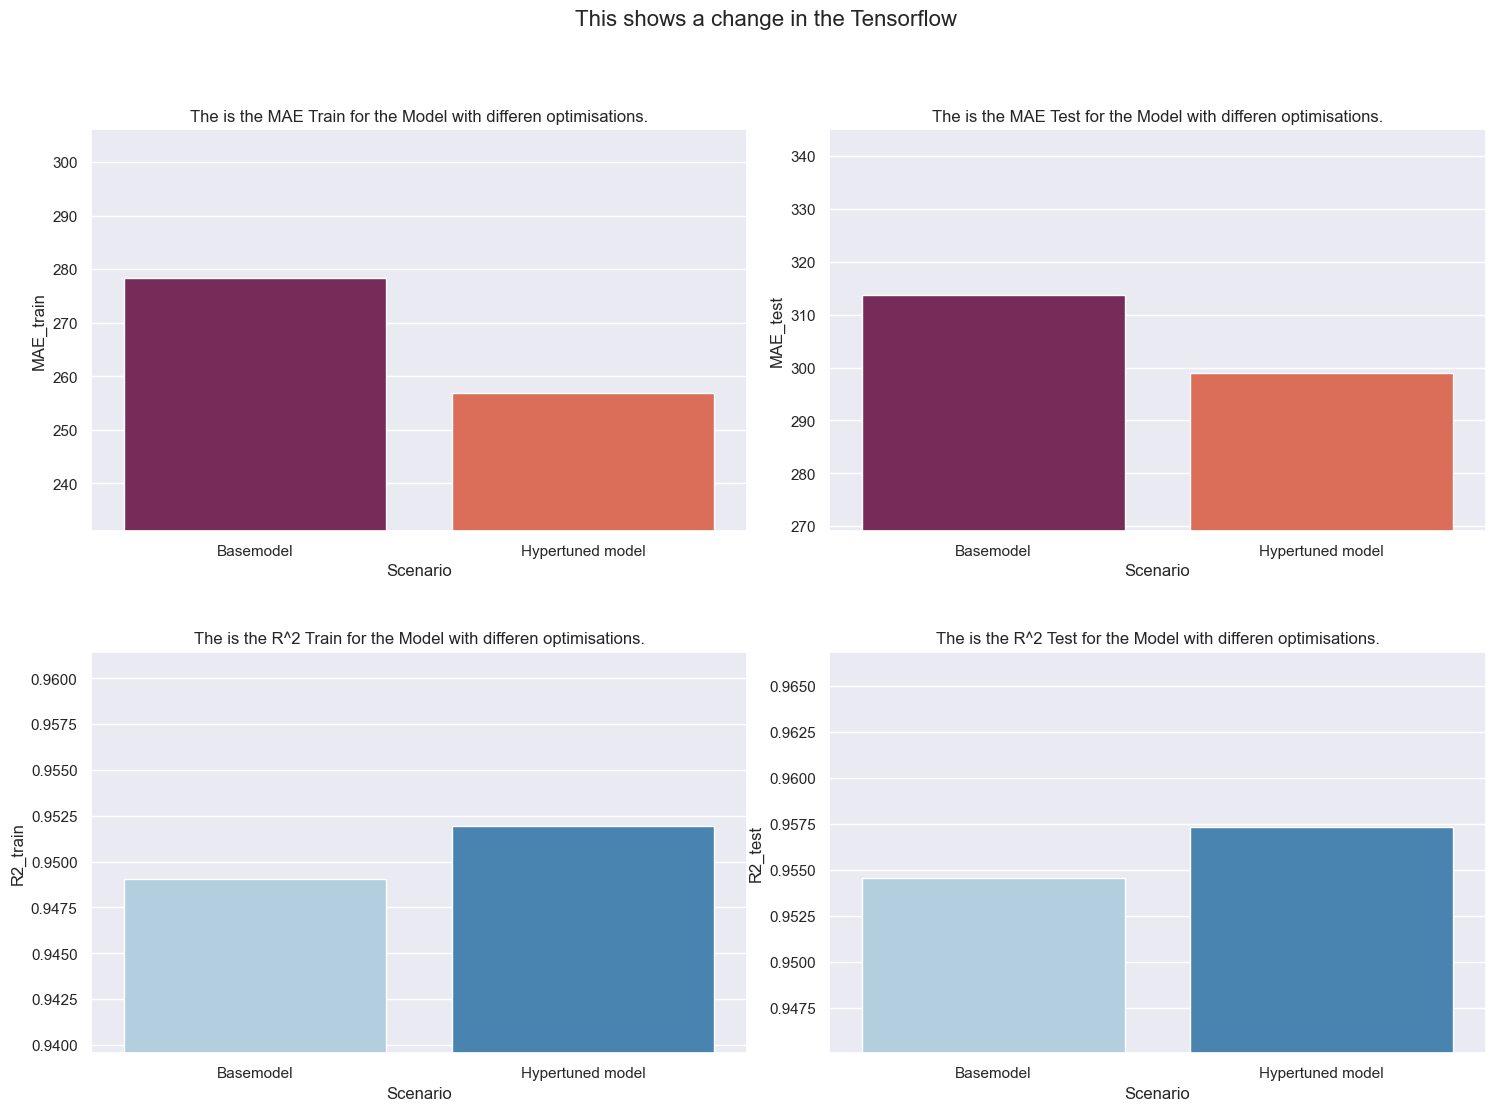

In [53]:
plot_bars_comp("Tensorflow", comparison)

### Hypertuned model fit on non pca data

In [63]:
### Non PCA Data
#Define df as our Dataset and drop not needed columns
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
X = df[df.columns[3:57]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [64]:
#Create a second Hypertuned Model to tune further, with the best Hyperparameter configurations the tuner has found.
tensorflow_non_pca_model = tensorflow_h1_tuner.hypermodel.build(h1_best_hps)

#Fitting the hypertuned model on 100% of the data. In order to compare it to the baseline model which was fitted on 100% of the data.
#This approach is choosen to reduce computing time, if this was not of concern the tuning would have been done on the whole dataset
tensorflow_non_pca_history = tensorflow_non_pca_model.fit(Xtrain, ytrain, epochs=250, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001, reducelr_p=10, stope_p=25))

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 20:02:14.226908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 792.4530 - mae: 792.4530 - r_square: 0.7586

2022-12-04 20:02:30.410706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 25s 66ms/step - loss: 792.4530 - mae: 792.4530 - r_square: 0.7586 - val_loss: 482.5943 - val_mae: 482.5943 - val_r_square: 0.9088 - lr: 0.0100
Epoch 2/250
269/269 [==============================] - 7s 27ms/step - loss: 480.9622 - mae: 480.9622 - r_square: 0.9049 - val_loss: 431.8144 - val_mae: 431.8144 - val_r_square: 0.9168 - lr: 0.0100
Epoch 3/250
269/269 [==============================] - 7s 26ms/step - loss: 430.9579 - mae: 430.9579 - r_square: 0.9155 - val_loss: 416.8521 - val_mae: 416.8521 - val_r_square: 0.9169 - lr: 0.0100
Epoch 4/250
269/269 [==============================] - 7s 26ms/step - loss: 404.0904 - mae: 404.0904 - r_square: 0.9222 - val_loss: 381.1730 - val_mae: 381.1730 - val_r_square: 0.9249 - lr: 0.0100
Epoch 5/250
269/269 [==============================] - 7s 26ms/step - loss: 388.5934 - mae: 388.5934 - r_square: 0.9253 - val_loss: 367.8087 - val_mae: 367.8087 - val_r_square: 0.9283 - lr: 0.0100
Epoch 6/250
269/269 [=====

2022-12-04 20:17:08.904030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 3s 13ms/step


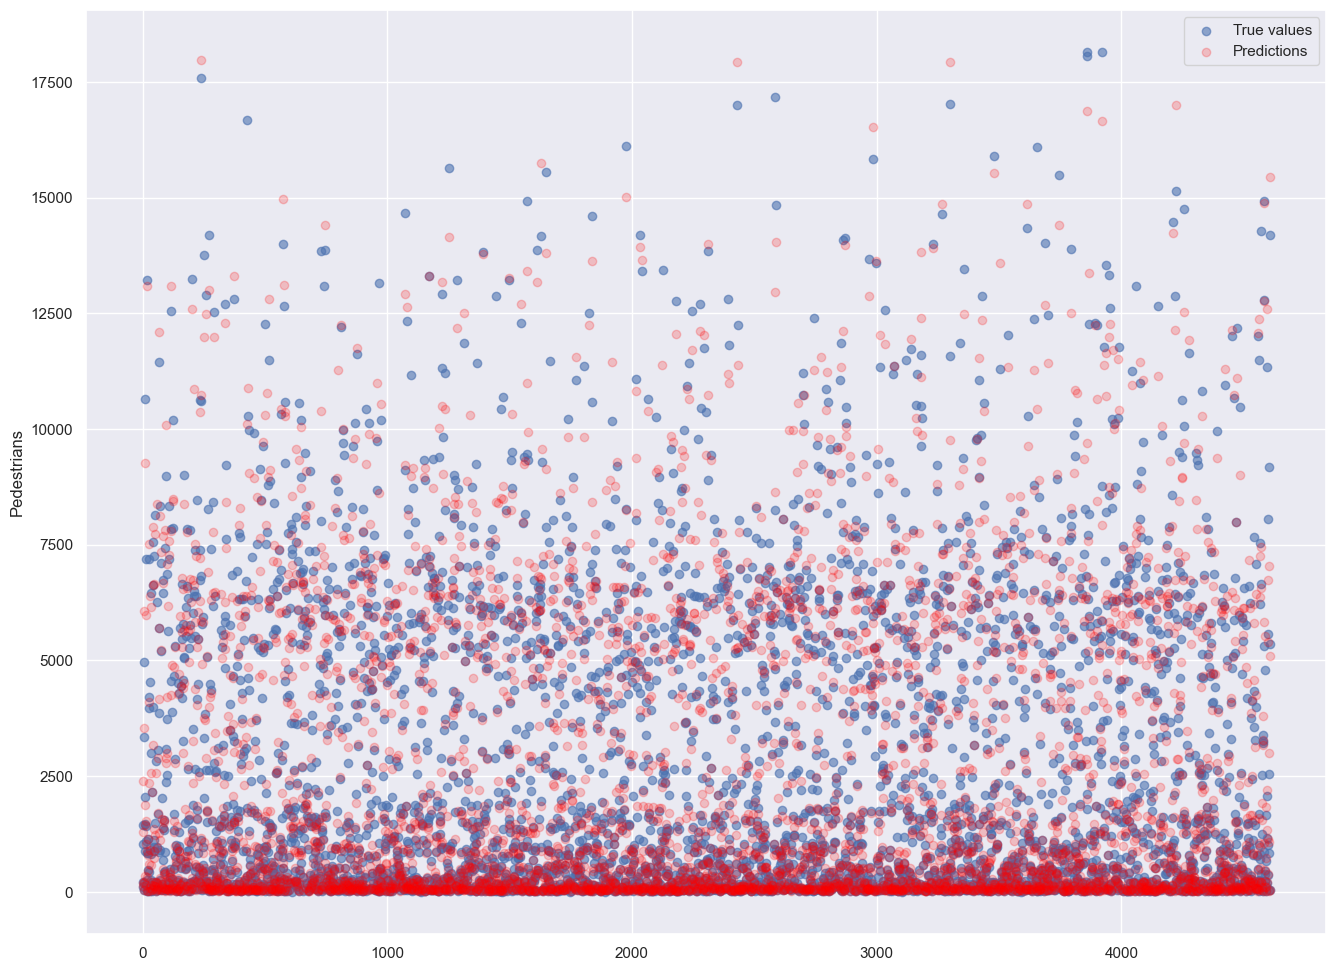

In [65]:
#Visualize the results predictions vs actual values
plot_baseline(tensorflow_non_pca_model, Xtest, ytest)

144/144 [==============================] - 2s 10ms/step - loss: 287.8586 - mae: 287.8586 - r_square: 0.9579


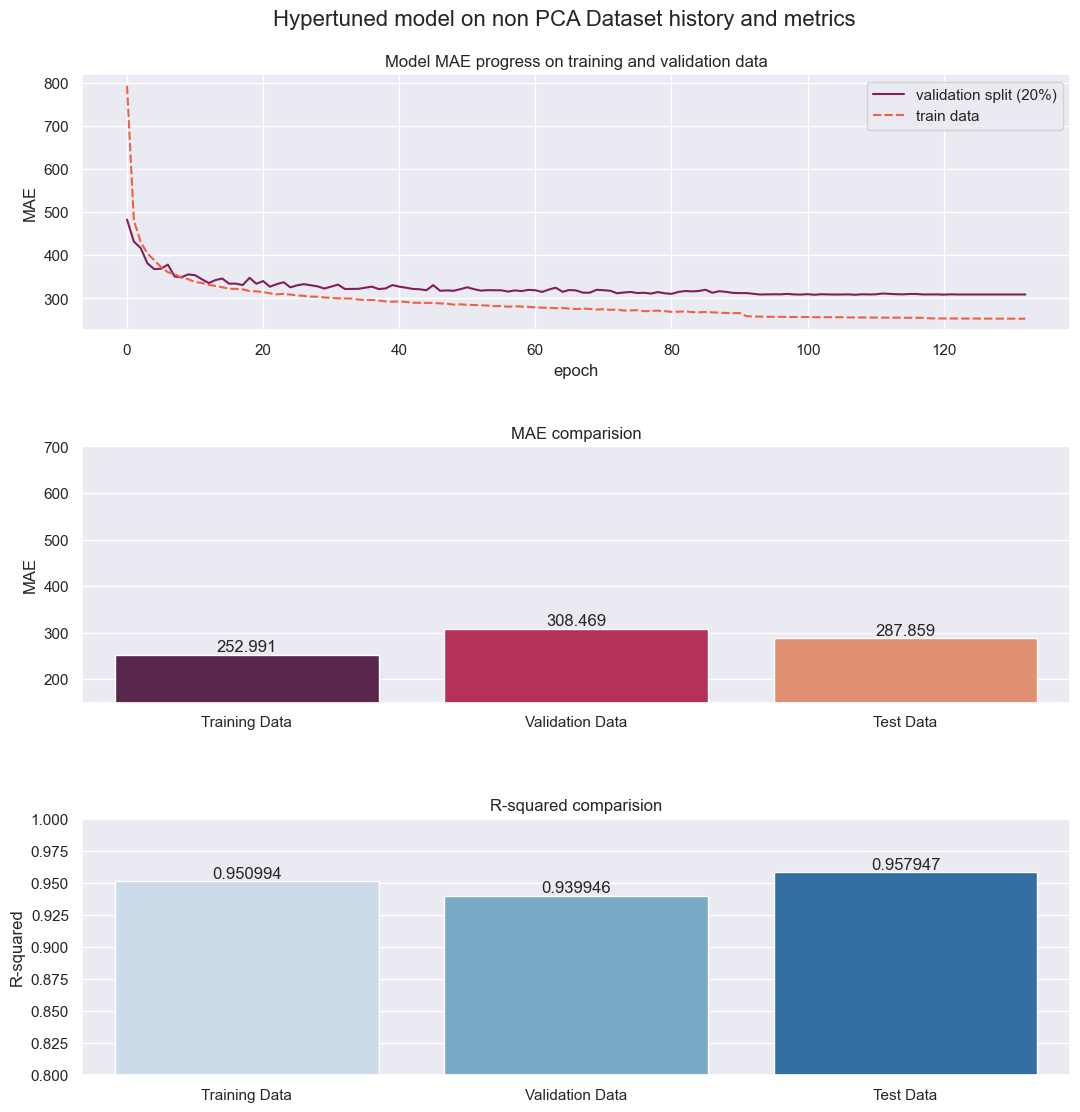

In [66]:
#Plot the MAE on the training data against the validation split of the Training data over time, aswell as the MAE and R-squared on the Trainind data, validation data and Test Data
tensorflow_history_plot(history=tensorflow_non_pca_history, model=tensorflow_non_pca_model, testdataX=Xtest, testdatay=ytest, name="Hypertuned model on non PCA Dataset")